In [1]:
# Import core libraries and NUGGET modules
import torch
import numpy as np
import nugget  # Main NUGGET package for neutrino detector optimization
import matplotlib.pyplot as plt
import importlib

In [3]:
# Create a skewed Gaussian surrogate for light yield prediction
Skewedgauss = nugget.surrogates.SkewedGaussian.SkewedGaussian(sigma_factor=6) 
light_yield_surrogate = Skewedgauss.light_yield_surrogate

# Initialize event samplers for signal and background events
signal_sampler = nugget.samplers.toy_sampler.ToySampler(x_bias=0, event_type='signal', domain_size=4)
background_sampler = nugget.samplers.toy_sampler.ToySampler(x_bias=0, event_type='background', domain_size=4)

In [4]:
# Sample a single signal event and detector coordinate for testing
signal_event = signal_sampler.sample_events(1)  # Generate one signal event with physics parameters
coordinate = signal_sampler.sample_detector_points(1)  # Sample a detector position

In [5]:
# Test the light yield surrogate: predict light output at detector position for given event
light_yield_surrogate(opt_point=coordinate, event_params=signal_event[0])

tensor([0.5536])

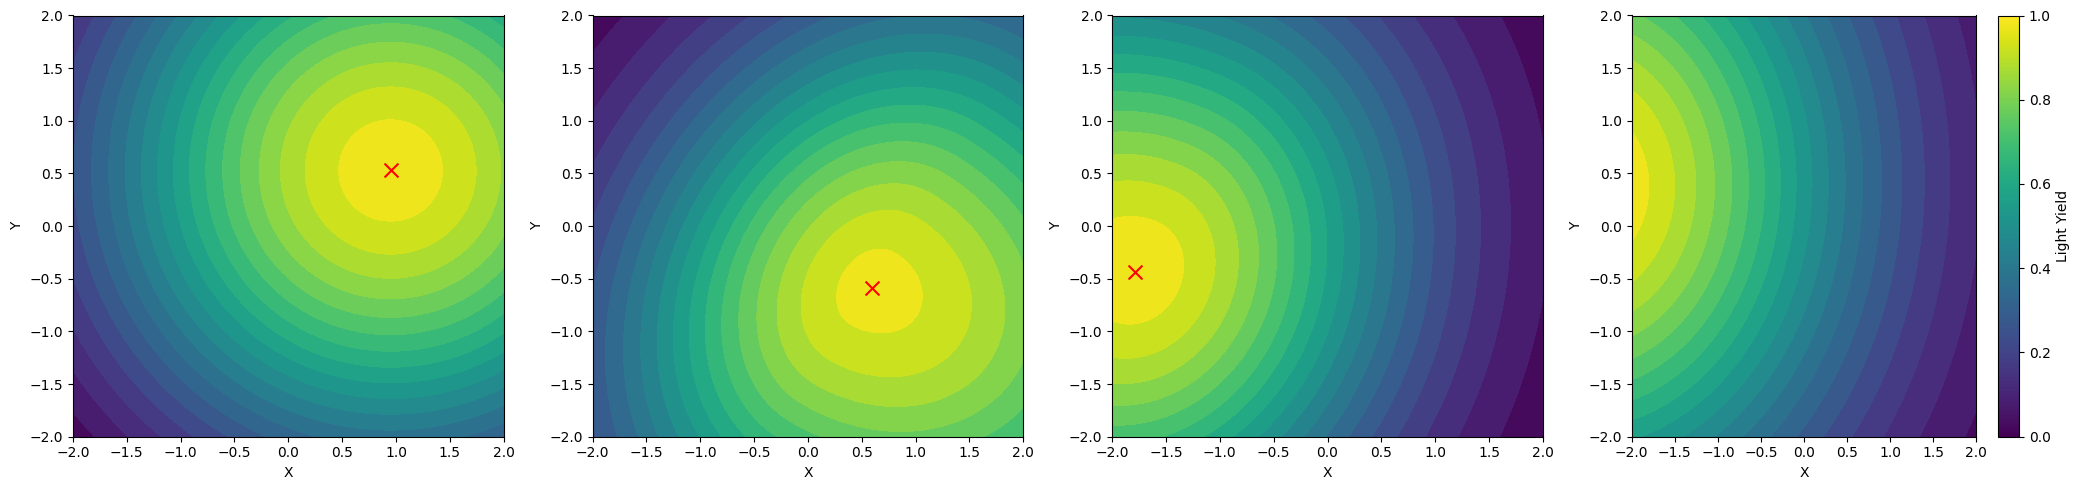

In [6]:
# visualize some signal events and their light yield distribution
test_points_x = torch.linspace(-2, 2, steps=70)
test_points_y = torch.linspace(-2, 2, steps=70)
test_points_z = torch.zeros(70)  # Assuming z=0 for a 2D plane
# create a meshgrid of test points, at each point we have (x,y,0)
for i in range(70):
    for j in range(70):
        if i == 0 and j == 0:
            test_points = torch.tensor([[test_points_x[i], test_points_y[j], test_points_z[j]]])
        else:
            test_points = torch.cat((test_points, torch.tensor([[test_points_x[i], test_points_y[j], test_points_z[j]]])), dim=0)
fig, axes = plt.subplots(1,4, figsize=(21,5))
for i in range(4):
    event = signal_sampler.sample_events(1)
    event[0]['position'][0][2] = 0  # Set z=0 for visualization
    light_yield = light_yield_surrogate(opt_point=test_points, event_params=event[0])
    light_yield = light_yield.reshape(70, 70).T  # Reshape to a 2D grid
    axes[i].contourf(test_points_x.numpy(), test_points_y.numpy(), light_yield.numpy(), cmap='viridis', levels=20)
    # axes[i].set_title(f'Event {i+1} at {list(event[0]['position'].detach().numpy()):.2f}')
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')
    
    axes[i].scatter(event[0]['position'][0][0].numpy(), event[0]['position'][0][1].numpy(), color='red', marker='x', s=100, label='Event Position')
    axes[i].set_xlim([-2, 2])
    axes[i].set_ylim([-2, 2])
    if i == 3:
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=axes[i], )
        cbar.set_label('Light Yield')
plt.tight_layout()
        


In [7]:
# Create and configure the Log-Likelihood Ratio Neural Network (LLRnet)
llr_net = nugget.surrogates.LLRnet.LLRnet(
    domain_size=4,  # Size of the detector domain
    dim=3,  # 3D spatial coordinates
    hidden_dims=[256, 128, 64, 32],  # Neural network architecture
    use_fourier_features=True,  # Use Fourier features for better spatial encoding
    num_parallel_branches=2,  # Multiple branches for ensemble learning
    frequency_scales=[0.1, 0.2],  # Different frequency scales for fourier features
    num_frequencies_per_branch=[64,64],  # Number of Fourier features per branch
    learnable_frequencies=False,  # Fixed frequency features
    dropout_rate=0.1,  # Regularization
    learning_rate=1e-3,  # Optimizer learning rate
    shared_mlp=False,  # Independent MLPs for each branch
    use_residual_connections=True,  # Skip connections for better training
    signal_noise_scale=0.05,  # Noise level for signal events
    background_noise_scale=0.2,  # Noise level for background events
    add_relative_pos=False  # Whether to include relative position features
)

In [8]:
# Create data loaders for training, validation, and testing the LLR network
# Training data loader - larger batches for efficient training
train_dataloader = llr_net.create_event_dataloader(
    signal_sampler=signal_sampler, 
    background_sampler=background_sampler,
    batch_size=128,  # Training batch size
    num_workers=4,  # Parallel data loading
    signal_surrogate_func=light_yield_surrogate,  # Function to compute light yield for signals
    background_surrogate_func=light_yield_surrogate,  # Function for background light yield
    num_samples_per_epoch=10000,  # Total samples per training epoch
    event_labels=['position', 'energy', 'zenith', 'azimuth'],  # Event parameters to include
    shuffle=False
)

# Validation data loader - smaller batches for evaluation during training
val_dataloader = llr_net.create_event_dataloader(
    signal_sampler=signal_sampler,
    background_sampler=background_sampler,
    batch_size=32,  # Smaller validation batch size
    num_workers=2,
    signal_surrogate_func=light_yield_surrogate,
    background_surrogate_func=light_yield_surrogate,
    num_samples_per_epoch=1000,  # Fewer validation samples
    event_labels=['position', 'energy', 'zenith', 'azimuth'],
    shuffle=False
)

# Test data loader - includes true light yield for analysis
test_dataloader = llr_net.create_event_dataloader(
    signal_sampler=signal_sampler,
    background_sampler=background_sampler,
    batch_size=50,
    num_workers=2,
    num_samples_per_epoch=10000,
    signal_surrogate_func=light_yield_surrogate,
    background_surrogate_func=light_yield_surrogate,
    event_labels=['position', 'energy', 'zenith', 'azimuth'],
    shuffle=False, 
    output_true_light_yield=True  # Include ground truth for analysis
)

In [ ]:
# Train the LLR network to distinguish between signal and background events
history = llr_net.train_with_dataloader(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=800,  # Maximum number of training epochs
    early_stopping_patience=50  # Stop if validation doesn't improve for 50 epochs
)
# Save the best model for later use
llr_net.save_model('best_toy_model')

In [9]:
# Load the trained model
llr_net.load_model('best_toy_model')

Building parallel network architecture:
  Input dim: 10
  Number of parallel branches: 2
  Shared MLP: False
  Branch 0: 64 frequencies, scale 0.100, output dim 128
  Branch 1: 64 frequencies, scale 0.200, output dim 128
  Branch 0 MLP with residual connections: 128 -> [256, 128, 64, 32] -> 32
  Branch 1 MLP with residual connections: 128 -> [256, 128, 64, 32] -> 32
  Final MLP: 64 -> 32 -> 1
  Total trainable parameters: 243,201
  Total trainable parameters: 243,201


In [14]:
# Generate new event samples for geometry optimization
new_signal_events = signal_sampler.sample_events(250)  # Fresh signal events for optimization
new_background_events = background_sampler.sample_events(250)  # Fresh background events

In [36]:
# Initialize an EvanescentString geometry for detector optimization
# EvanescentString allows strings to "fade out" by reducing their weights during optimization
geometry = nugget.geometries.EvanescentString.EvanescentString(
    domain_size=4,  # Size of detector domain
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),  # Use GPU if available
    dim=3,  # 3D geometry
    n_strings=1000,  # Initial number of detector strings
    points_per_string=5,  # Number of PMTs/sensors per string
    starting_weight=2,  # Initial weight for each string (controls visibility)
)

In [ ]:

# Visualizer for creating plots and animations during optimization
visualizer = nugget.utils.vis_tools.Visualizer(
    device=geometry.device,
    dim=geometry.dim, 
    domain_size=geometry.domain_size,
    gif_temp_dir='gif_temp',  # Directory for storing animation frames
)

# Main optimizer that coordinates geometry updates and loss computation
optimizer = nugget.utils.basic_optimizer.Optimizer(
    device=geometry.device, 
    geometry=geometry,
    visualizer=visualizer,
    conflict_free=False,  # Single-objective optimization (vs multi-objective)
    use_custom_cf_weight=False,
)

# Initialize the geometry with optimization parameters
# string_weights controls which strings are active (learnable parameter)
optimizer.init_geometry(opt_list=[('string_weights', 0.1)],   # Learning rate for string weights (without sigmoid applied)
    # geom_dict=pickle.load(open('best_geom.pkl', 'rb')) # Load a previously saved geometry to continue optimization
)

Optimizing string_weights with torch.Size([1000]) shape


In [ ]:
# Check the minimum distance between detector strings
string_xy = optimizer.geom_dict['string_xy']  # Get (x,y) positions of all strings
dists = np.linalg.norm(string_xy[:, None, :] - string_xy[None, :, :], axis=-1)  # Pairwise distances
print(min(dists[dists > 0]))  # Minimum non-zero distance between strings

0.11111033


In [ ]:
# Define loss functions and penalties for geometry optimization

# === PHYSICS-BASED LOSS FUNCTIONS ===
# Weighted LLR Loss: Maximizes log-likelihood ratio using trained neural network
signal_llr_loss_func = nugget.losses.LLR.WeightedLLRLoss(
    device=geometry.device,
    llr_net=llr_net,  # Use our trained LLR network
    no_grad=True  # Don't backprop through the network (frozen)
)

background_llr_loss_func = nugget.losses.LLR.WeightedLLRLoss(
    device=geometry.device,
    llr_net=llr_net,
    no_grad=True
)

# Light Yield Loss: Maximizes total light collected by detector
signal_yield_loss_func = nugget.losses.light_yield.WeightedLightYieldLoss(
    device=geometry.device,
)

# Fisher Information Loss: Maximizes information content for parameter estimation
fisher_info_loss_func = nugget.losses.fisher_info.WeightedFisherInfoLoss(
    device=geometry.device,
)

# Differential LLR Loss: Maximizes difference in LLR between signal and background
weighted_dif_llr_loss = nugget.losses.LLR.WeightedMeanDifLLRLoss(
    llr_net=llr_net,
    no_grad=True,
    device=geometry.device
)

# === GEOMETRY PENALTY FUNCTIONS ===
# These prevent unphysical detector configurations

# Local String Repulsion: Prevents strings from getting too close to each other
local_string_repulsion_penalty = nugget.losses.geometry_penalties.LocalStringRepulsionPenalty(
    device=geometry.device
)

# String Boundary Penalty: Keeps strings within the detector domain
string_boundary_penalty = nugget.losses.geometry_penalties.StringBoundaryPenalty(
    device=geometry.device,
)

# String Repulsion: Global repulsion between all strings
string_repulsion_penalty = nugget.losses.geometry_penalties.StringRepulsionPenalty(
    device=geometry.device
)

# String Weights Penalty: Encourages sparse solutions (fewer active strings)
string_weights_penalty = nugget.losses.geometry_penalties.StringWeightsPenalty(
    device=geometry.device
)

# String Number Penalty: Penalizes having too many active strings
string_number_penalty = nugget.losses.geometry_penalties.StringNumberPenalty(
    device=geometry.device
)

# Weight Binarization: Encourages string weights to be either 0 or 1
weighted_binarization_penalty = nugget.losses.geometry_penalties.WeightBinarizationPenalty(
    device=geometry.device
)

# === RESOLUTION-BASED LOSSES ===
# Angular Resolution: Optimizes detector's ability to reconstruct particle direction
weighted_angular_resolution_loss = nugget.losses.fisher_info.WeightedResolutionLoss(
    device=geometry.device,
    resolution_type='angular'
)

# Energy Resolution: Optimizes detector's ability to reconstruct particle energy
weighted_energy_resolution_loss = nugget.losses.fisher_info.WeightedResolutionLoss(
    device=geometry.device,
    resolution_type='energy'
)

# ROV Penalty: Accounts for physical constraints from Remotely Operated Vehicle
rov_penalty = nugget.losses.geometry_penalties.ROVPenalty(
    device=geometry.device, 
    rov_rec_width=0.4,  # ROV dimensions
    rov_height=0.24, 
    rov_tri_length=0.12
)

# === LOSS FUNCTION PARAMETERS ===
loss_params = {
    'llr_net': llr_net,
    'signal_event_params': new_signal_events,   
    'background_event_params': new_background_events,
    'signal_surrogate_func': light_yield_surrogate,  # Function to compute light yield
    'background_surrogate_func': light_yield_surrogate,
    'signal_sampler': signal_sampler,
    'background_sampler': background_sampler,
    'num_events': 50,  # Number of events to sample per optimization step
    'signal_noise_scale': 0.05,  # Noise level for signal events
    'background_noise_scale': 0.2,  # Noise level for background events
    'boundary_range': 2  # Size of boundary region
}

# Additional parameters for evanescent string optimization
loss_params.update({
    'eva_min_num_strings': 70,  # Minimum number of active strings
    'max_radius': 0.12  # Maximum radius for string placement
})

# === ACTIVE LOSS FUNCTIONS ===
# Select which loss functions to use in optimization
loss_func_dict = {
    # 'angular_resolution_loss': weighted_angular_resolution_loss,
    # 'energy_resolution_loss': weighted_energy_resolution_loss,
    # 'fisher_loss': fisher_info_loss_func, 
    'signal_yield_loss': signal_yield_loss_func,  # Maximize light collection
    'signal_llr_loss': signal_llr_loss_func,      # Maximize signal discrimination
    'local_string_repulsion_penalty': local_string_repulsion_penalty,
    # 'string_repulsion_penalty': string_repulsion_penalty,
    'string_weights_penalty': string_weights_penalty,  # Encourage sparsity
    'string_number_penalty': string_number_penalty,    # Limit number of strings
    'rov_penalty': rov_penalty,
    'string_boundary_penalty': string_boundary_penalty,  # Keep strings in bounds
    #   'weight_binarization_penalty': weighted_binarization_penalty
}

# === LOSS WEIGHTS ===
# Relative importance of each loss component
loss_weights_dict = {
    'angular_resolution_loss': 0,
    'energy_resolution_loss': 0,
    'fisher_loss': 0.005, 
    'signal_yield_loss': 1e3,        # High weight: maximize light collection
    'signal_llr_loss': 2.5,          # Moderate weight: good signal discrimination
    'string_boundary_penalty': 100000,  # Very high: hard constraint
    'local_string_repulsion_penalty': 1,
    'string_repulsion_penalty': 0.000001,
    'string_weights_penalty': 5,     # Encourage sparse solutions
    'string_number_penalty': 5,      # Limit detector complexity
    'weight_binarization_penalty': 0.01,
    # 'rov_penalty': 0.01
}

# Custom weights for conflict-free optimization 
# cf_loss_weights_dict = {
#     'fisher_loss': 0.01, 
#     'signal_yield_loss': 0.0005,
#     'signal_llr_loss': 0.001,
#     'local_string_repulsion_penalty': 10000,
#     'string_repulsion_penalty': 1,
#     'string_weights_penalty': 100,
#     'string_number_penalty': 10000,
#     'weight_binarization_penalty': 0.01,
#     'string_boundary_penalty': 10000,
#     'rov_penalty': 100
# }

# === VISUALIZATION SETUP ===
# Types of plots to generate during optimization, see vis_tools.py for all options
plot_types = [
    'loss_components',           # Loss function values over time
    'uw_loss_components',        # Unweighted loss components (transformed to [1e-2,1])
    'string_weights_scatter',    # String weight visualization
    'signal_llr_contour',        # LLR spatial distribution for signals (needs signal LLR loss active)
    'signal_light_yield_contour', # Light yield spatial distribution (needs signal yield loss active)
    # 'fisher_info_contour',     # Fisher information distribution (needs fisher loss active)
    # 'angular_resolution',      # Angular resolution maps (needs resolution loss active)
    # 'energy_resolution',       # Energy resolution maps (need energy resolution loss active)
]
# additional arguments for the visualizer
vis_kwargs = {
    'plot_types': plot_types,
    'slice_res': 50,             # Resolution of spatial plots
    'multi_slice': True,         # Generate multiple depth slices
    'gif_plot_selection': plot_types,  # Which plots to include in animation
    'loss_filter': ['string_boundary_penalty', 'string_number_penalty', ],  # Filter out noisy loss components
    'rov_penalty': rov_penalty
}

In [ ]:
# Pre-compute LLR values for each string to speed up optimization
# This avoids recomputing the same values repeatedly during optimization
precomputed_signal_llr_per_string = signal_llr_loss_func.compute_LLR_per_string(
    string_xy=optimizer.geom_dict['string_xy'],      # String positions
    points_3d=optimizer.geom_dict['points_3d'],      # 3D coordinates of all detectors
    event_params=new_signal_events,                  # Signal events to evaluate
    surrogate_func=light_yield_surrogate             # Light yield function
)

In [ ]:
# Pre-compute light yield values for each string
precomputed_signal_yield_per_string = signal_yield_loss_func.light_yield_per_string(
    string_xy=optimizer.geom_dict['string_xy'],
    points_3d=optimizer.geom_dict['points_3d'],
    event_params=new_signal_events,
    surrogate_func=light_yield_surrogate
)

In [ ]:
# Pre-compute Fisher information for each string and event combination
precomputed_fisher_info_per_string_per_event = weighted_angular_resolution_loss.compute_fisher_info_per_string_per_event(
    string_xy=optimizer.geom_dict['string_xy'],
    points_3d=optimizer.geom_dict['points_3d'],
    signal_event_params=new_signal_events,
    signal_surrogate_func=light_yield_surrogate,
)

In [ ]:
# Save pre-computed values to disk for later use
# torch.save(precomputed_fisher_info_per_string, './precomputed_fisher_info_per_string_ly.pt')
torch.save(precomputed_signal_yield_per_string, './precomputed_signal_yield_per_string.pt')
torch.save(precomputed_signal_llr_per_string, './precomputed_signal_llr_per_string.pt')
torch.save(precomputed_fisher_info_per_string_per_event, './precomputed_fisher_info_per_string_per_event_ly.pt')

In [ ]:
# Alternative: Load pre-computed values from disk (if available)
precomputed_fisher_info_per_string_per_event = torch.load('./precomputed_fisher_info_per_string_per_event_ly.pt')
precomputed_signal_yield_per_string = torch.load('./precomputed_signal_yield_per_string.pt')
precomputed_signal_llr_per_string = torch.load('./precomputed_signal_llr_per_string.pt')

In [ ]:
# Add pre-computed values to loss parameters
loss_params.update({
    'precomputed_signal_llr_per_string': precomputed_signal_llr_per_string,
    'precomputed_signal_yield_per_string': precomputed_signal_yield_per_string,
    # 'precomputed_fisher_info_per_string': precomputed_fisher_info_per_string,
    'precomputed_fisher_info_per_string_per_event': precomputed_fisher_info_per_string_per_event
})

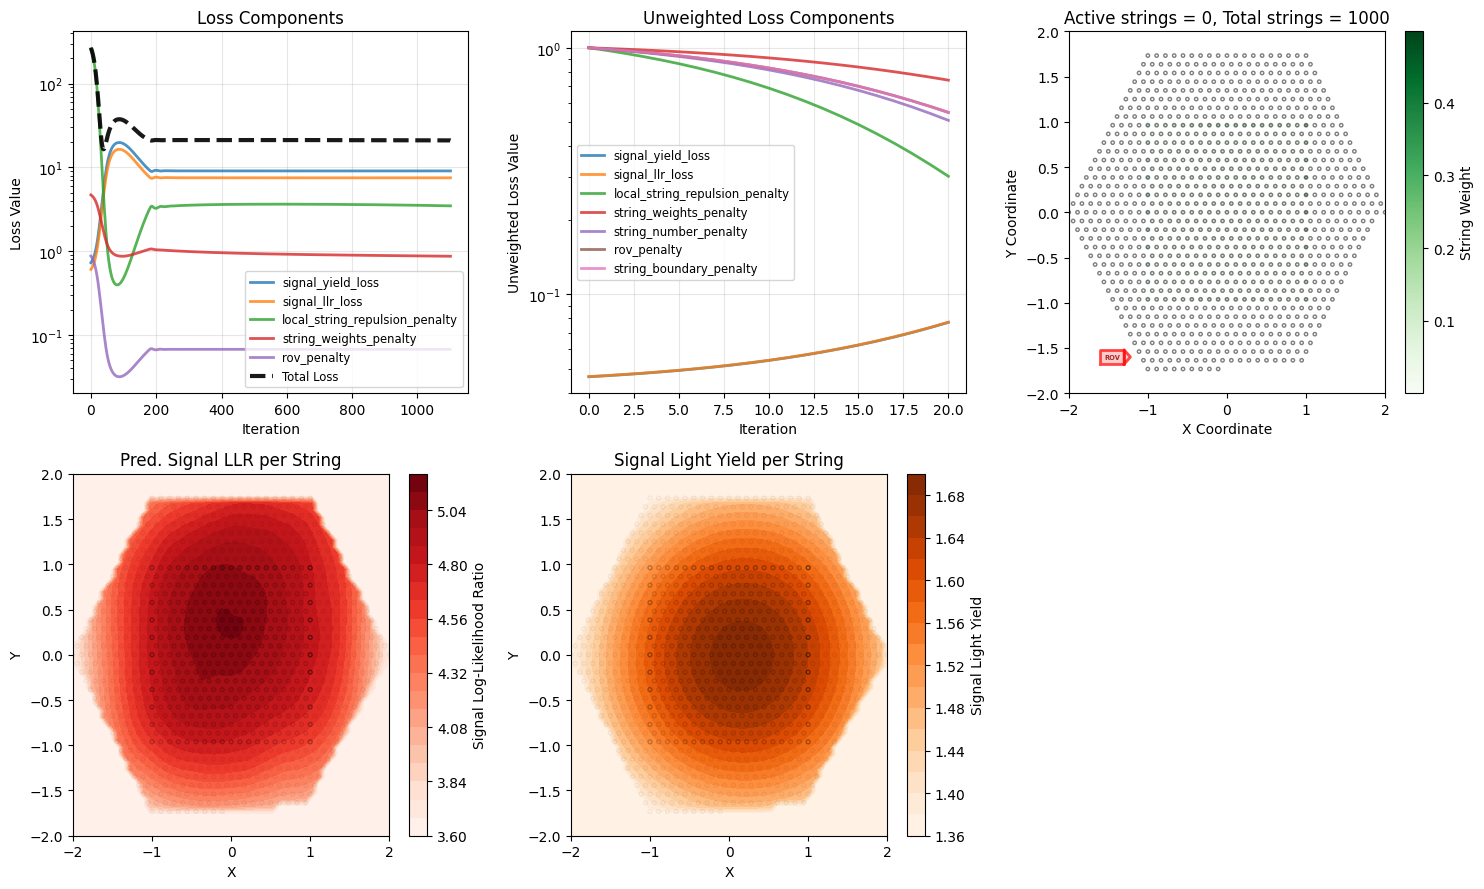

Saved GIF frame 206 to /var/folders/40/hq_tym9s6_vcj1qtwjlrl3lw0000gn/T/gif_frames_r03s0lbv/frame_100754.png


: 

In [ ]:
# Run the main geometry optimization loop
# optimizer.visualizer.cleanup_gif_temp_files()  # Clean up any old visualization files
geom_dict = optimizer.optimize(
    loss_func_dict=loss_func_dict,          # Dictionary of loss functions to use
    loss_weights_dict=loss_weights_dict,    # Weights for combining multiple losses
    loss_params_dict=loss_params,           # Parameters for loss function computation
    save_best_geom_file = 'best_geom.pkl',  # File to save best geometry found (lowest total loss)
    n_iter=1000,                           # Maximum number of optimization iterations
    vis_kwargs=vis_kwargs,                 # Visualization parameters
    print_freq=5,                          # Print progress every N iterations
    vis_freq=10,                           # Create plots every N iterations
    gif_freq=5,                           # Save animation frames every N iterations
    # cf_loss_weights_dict=cf_loss_weights_dict,  # custom weights for conflict-free optimization
    # loss_dict=optimizer.loss_dict,         # resupply loss histories if continuing optimization (only for visualization)
    # uw_loss_dict=optimizer.uw_loss_dict,   
    # vis_loss_dict=optimizer.vis_loss_dict, 
    # vis_uw_loss_dict=optimizer.vis_uw_loss_dict  
)

In [ ]:
# Create an animated GIF showing the optimization process
optimizer.visualizer.finalize_gif(
    gif_filename='../gifs/opt_test.gif',  # Output filename
    gif_fps=10,                    # Animation frame rate
    cleanup_images=False           # Keep individual frames for debugging
)

In [ ]:
# Create an interactive 3D plot of the optimized detector geometry
optimizer.visualizer.create_interactive_3d_plot(
    points_3d=optimizer.geom_dict['points_3d'],           # 3D coordinates of all detector elements
    string_xy=optimizer.geom_dict['string_xy'],           # (x,y) positions of string centers
    string_weights=optimizer.geom_dict['string_weights'], # Learned weights (opacity) for each string
    weight_threshold=0.7,                                 # Only show strings above this weight
    points_per_string_list=optimizer.geom_dict['points_per_string_list']  # Number of detectors per string
)

In [ ]:
# Initialize a different geometry type: DynamicString
# DynamicString allows both string positions and individual detector positions to be optimized
new_geometry = nugget.geometries.DynamicString.DynamicString(
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
)

In [ ]:
# Set up a new optimizer for the DynamicString geometry
visualizer = nugget.utils.vis_tools.Visualizer(
    device=new_geometry.device,
    dim=new_geometry.dim, 
    domain_size=new_geometry.domain_size,
    gif_temp_dir='gif_temp'
)

optimizer = nugget.utils.basic_optimizer.Optimizer(
    device=new_geometry.device, 
    geometry=new_geometry,
    visualizer=visualizer,
    conflict_free=False
)

# Initialize with different optimization parameters:
# - string_xy: optimize string center positions
# - z_values: optimize vertical positions of individual detectors
# Use the previous optimization result as a starting point
optimizer.init_geometry(opt_list=[('string_xy', 0.01), ('z_values', 0.01)], geom_dict=geom_dict)

Using pre-trained dynamic string geometry as starting point
Filtering strings: 63 out of 500 strings active
Filtered string_xy to 63 strings
Filtered z_values from 2500 to 315 points
Created per-point string_indices for active strings, total_points now: 315
Optimizing string_xy with torch.Size([63, 2]) shape
Optimizing z_values with torch.Size([315]) shape


In [ ]:
# Configure loss functions for DynamicString optimization
# Note: Using non-weighted versions since we're optimizing individual detector positions

signal_llr_loss_func = nugget.losses.LLR.LLRLoss(
    device=geometry.device,
    llr_net=llr_net,  # Same trained LLR network
)

# Light yield loss for individual detector optimization
signal_yield_loss_func = nugget.losses.light_yield.LightYieldLoss(
    device=geometry.device,
)

# Fisher information for individual detectors
fisher_info_loss_func = nugget.losses.fisher_info.FisherInfoLoss(
    device=geometry.device,
)

# === GEOMETRY PENALTIES FOR DYNAMIC STRINGS ===

# String repulsion: prevent strings from overlapping
string_repulsion_penalty = nugget.losses.geometry_penalties.StringRepulsionPenalty(
    device=geometry.device
)

# Local string repulsion: prevent nearby detectors from colliding
local_string_repulsion_penalty = nugget.losses.geometry_penalties.LocalStringRepulsionPenalty(
    device=geometry.device
)

# Z-distance repulsion: prevent detectors on same string from getting too close vertically
z_distance_repulsion_penalty = nugget.losses.geometry_penalties.ZDistRepulsionPenalty(
    device=geometry.device
)

# Boundary penalty: keep detectors within the allowed domain
boundary_penalty = nugget.losses.geometry_penalties.BoundaryPenalty(
    device=geometry.device
)

# === LOSS PARAMETERS FOR DYNAMIC OPTIMIZATION ===
loss_params = {
    'llr_net': llr_net,
    # Note: not using pre-computed metrics since string positions change each iteration
    # 'signal_event_params': new_signal_events, # if these are supplied, random events are sampled each iteration   
    # 'background_event_params': new_background_events,
    'signal_surrogate_func': light_yield_surrogate,
    'background_surrogate_func': light_yield_surrogate,
      'signal_noise_scale': 0.05,
    'background_noise_scale': 0.2,
    'signal_sampler': signal_sampler,           # these three parameters are needed if event params are not supplied
    'background_sampler': background_sampler,
    'num_events': 50,          # Number of events per optimization step
}

loss_params.update({
    'domain_size': 4,      # Smaller domain for fine-tuning
    'max_radius': 0.08     # Maximum distance for detector interactions
})

# === ACTIVE LOSS FUNCTIONS FOR DYNAMIC OPTIMIZATION ===
loss_func_dict = {
    # 'fisher_loss': fisher_info_loss_func, 
    'signal_yield_loss': signal_yield_loss_func,    # Maximize light collection
    'signal_llr_loss': signal_llr_loss_func,        # Maximize signal discrimination
    # 'string_repulsion_penalty': string_repulsion_penalty,
    'local_string_repulsion_penalty': local_string_repulsion_penalty,  # Prevent detector collisions
    'z_dist_repulsion_penalty': z_distance_repulsion_penalty,          # Maintain spacing along strings
    'boundary_penalty': boundary_penalty                                # Keep detectors in bounds
}

# === LOSS WEIGHTS FOR DYNAMIC OPTIMIZATION ===
loss_weights_dict = {
    # 'fisher_loss': 1e4, 
    # 'signal_yield_loss': 5e2,
    'signal_llr_loss': 100,                    # High weight on signal discrimination
    'string_repulsion_penalty': 0.01,
    'local_string_repulsion_penalty': 0.1,    # Prevent detector overlap
    'z_distance_repulsion_penalty': 0.0001,   # Gentle spacing along strings
    'boundary_penalty': 0.01                  # Soft boundary constraint
    #   'weight_binarization_penalty': 0.01
}

# === VISUALIZATION FOR DYNAMIC OPTIMIZATION ===
plot_types = [
    'loss_components',              # Track loss evolution
    '3d_points',                   # Show 3D detector positions
    # 'xy_projection',             # 2D projection of detector layout
    'signal_llr_contour_points',   # Spatial LLR maps with detector positions
    'signal_light_yield_contour_points',  # Light yield maps
]

vis_kwargs = {
    'plot_types': plot_types,
    'slice_res': 50,
    'multi_slice': True,
    'gif_plot_selection': plot_types
}

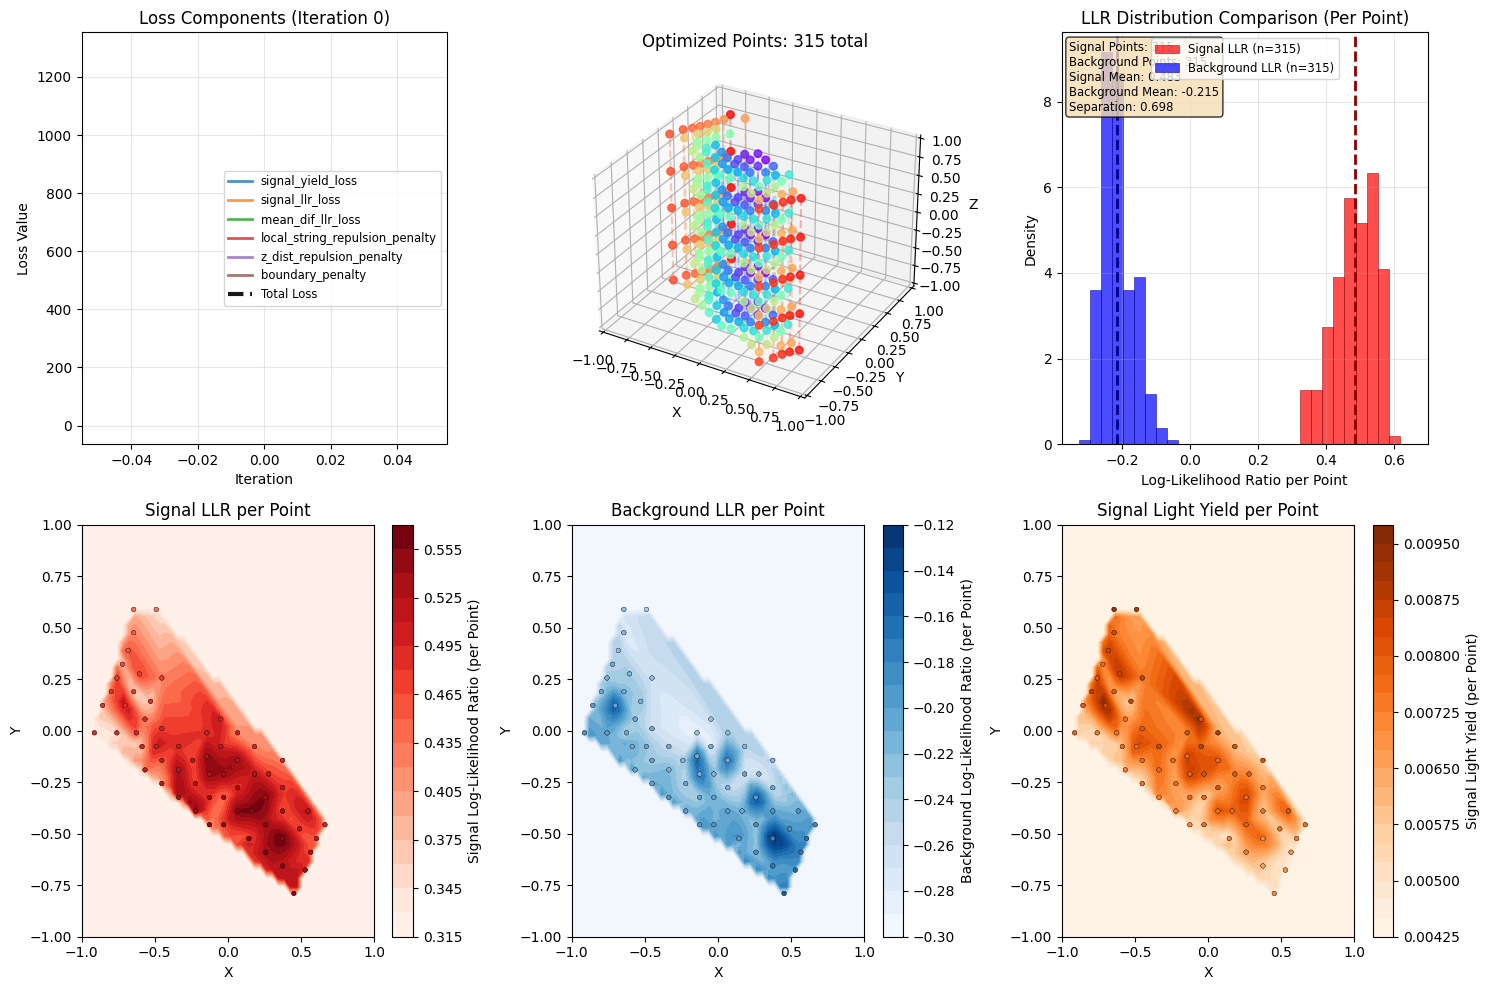

Saved GIF frame 1 to gif_temp/frame_0001.png
Iter 6/400, Total Loss: 1206.8055 | signal_yield_loss: 10.2275 | signal_llr_loss: 0.6109 | mean_dif_llr_loss: 2.5692 | local_string_repulsion_penalty: 3.0259 | z_dist_repulsion_penalty: 1190.3721 | boundary_penalty: 0.0000
Saved GIF frame 2 to gif_temp/frame_0007.png
Iter 11/400, Total Loss: 1164.0044 | signal_yield_loss: 10.9622 | signal_llr_loss: 1.3433 | mean_dif_llr_loss: 3.6456 | local_string_repulsion_penalty: 2.3679 | z_dist_repulsion_penalty: 1145.6853 | boundary_penalty: 0.0000
Saved GIF frame 3 to gif_temp/frame_0018.png


In [ ]:
# Run the second optimization phase: fine-tune individual detector positions
new_geom_dict = optimizer.optimize(
    loss_func_dict=loss_func_dict,
    loss_weights_dict=loss_weights_dict,
    loss_params_dict=loss_params,
    n_iter=400,                    # Fewer iterations for fine-tuning
    vis_kwargs=vis_kwargs,
    print_freq=5,
    vis_freq=20,                   # Less frequent visualization to save time
    gif_freq=5,
    alternate_freq=10              # Alternate between different optimization parameters (e.g. string_xy and z_values)
)